# Extracting tags from Bloomberg tweets using Flair (Phase 2A) 

A critical part of building a news tweet sentiment monitoring tool is the scrapping of specific tweets itself from twitter and classifying it into industry/geography buckets. For news tweets, I have chosen the Bloomberg's official twitter handle bearing the ID "@business". Also during my research to tackling the industry/geography classification, I found the flair library's, named entity recognition features quiet interesting and wanted to test its capabilities with Bloomberg's tweets.

An overview of the entire project can be accessed at: http://innovativespur.com/industry-sentiment-analysis-from-twitter-feed/

## Importing libraries for tweet import

For importing tweets from twitter I use the tweepy library available for python (https://www.tweepy.org/). My API credentials have been masked and imported into the project notebook through the "twitter_credentials" file. 

In [1]:
from tweepy import API
from tweepy import Cursor

from tweepy.streaming import StreamListener
from tweepy import OAuthHandler #Authentication with credentials
from tweepy import Stream #Live Stream API

import twitter_credentials

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Defining functions for retrieving tweets

I am defining the below 4 functions to help in retrieving the tweets:
1. authenticate_twitter_app: used to authenticate to the twitter API and return back the authenticated instance
2. retrive_tweets: returns a list of tweets, by accepting the twitter client, @username and number of tweets  parameters
3. retrive_search_tweets: returns a list of tweets, by accepting the twitter client, search term and number of tweets parameters
4. tweets_to_data_frame: accepts the tweet list with each item representing the tweet object returned by tweepy

In [2]:
def authenticate_twitter_app():
    auth = OAuthHandler(twitter_credentials.CONSUMER_KEY, twitter_credentials.CONSUMER_SECRET)
    auth.set_access_token(twitter_credentials.ACCESS_TOKEN, twitter_credentials.ACCESS_TOKEN_SECRET)
    return auth

In [3]:
def retrive_tweets(twitter_client ,user_id, no_of_tweets):
    tweets = []
    for tweet in Cursor(twitter_client.user_timeline, screen_name = user_id, tweet_mode = 'extended').items(no_of_tweets):
        tweets.append(tweet)
    return tweets

In [4]:
def retrive_search_tweets(twitter_client ,search, no_of_tweets):
    tweets = []
    for tweet in Cursor(twitter_client.search, q=search, tweet_mode = 'extended').items(no_of_tweets):
        tweets.append(tweet)
    return tweets

In [5]:
def tweets_to_data_frame(tweets):
    df = pd.DataFrame(data=[tweet.full_text for tweet in tweets], columns=['Tweets'])

    df['id'] = np.array([tweet.id for tweet in tweets])
    df['len'] = np.array([len(tweet.full_text) for tweet in tweets])
    df['date'] = np.array([tweet.created_at for tweet in tweets])
    df['coordinates'] = np.array([tweet.coordinates for tweet in tweets])
    df['source'] = np.array([tweet.source for tweet in tweets])
    df['likes'] = np.array([tweet.favorite_count for tweet in tweets])
    df['retweets'] = np.array([tweet.retweet_count for tweet in tweets])
    return df

## Retrieving tweets

To pull "Bloomberg" tweets from twitter, below I am authenticating the twitter API using the above defined function. Then an API instance is defined using the authenticated instance.

In [6]:
auth = authenticate_twitter_app()

twitter_client = API(auth)

export_file_path = 'D:\AI\Projects\Live_Sentiment_Analysis'

User ID of Bloomberg is @business. This ID was passed into the retrive_tweets function defined above and a list of 2,000 tweets were retrieved.  This list of tweets were further passed into the tweets_to_data_frame function to get the dataframe of tweets. 

In [7]:
user_id = 'business'
no_of_tweets = 2000
tweets = retrive_tweets(twitter_client ,user_id, no_of_tweets)
df = tweets_to_data_frame(tweets)
df.to_csv(r'D:\AI\Projects\Live_Sentiment_Analysis\tweets.csv', index = False, header=True)

## Loading retrieved tweets

Loading into the notebook, tweets retrieved before.

In [8]:
data = pd.read_csv('tweets.csv')
data.head()

,Tweets,id,len,date,coordinates,source,likes,retweets
0,RT @economics: Coronavirus cases in Latin Amer...,1279812255178203137,140,2020-07-05 16:19:54,NaN,SocialFlow,0,8
1,A group of bankers marched into a U.S. Treasur...,1279811059117948930,168,2020-07-05 16:15:08,NaN,SocialFlow,12,11
2,How the pandemic is changing the outlook for p...,1279810554094407683,77,2020-07-05 16:13:08,NaN,SocialFlow,17,14
3,Restaurants say top tables once impossible to ...,1279810040367546375,127,2020-07-05 16:11:06,NaN,SocialFlow,13,7
4,U.S. Labor Secretary Eugene Scalia said the ec...,1279808986884308992,145,2020-07-05 16:06:54,NaN,SocialFlow,23,13


## Importing the Flair library and NER model

1. To know more about Flair visit : https://github.com/flairNLP/flair
2. To know more about NER pre-trained models visit : https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_2_TAGGING.md

In [9]:
from flair.data import Sentence
from flair.models import SequenceTagger

tagger = SequenceTagger.load('ner')

2020-07-05 21:52:42,782 loading file C:\Users\govin\.flair\models\en-ner-conll03-v0.4.pt


## Named Entity Recognition using Flair

Steps under this stage is as below:
1. The tweets are converted into a list and converted into a sentence object list
2. These sentence objects are then converted into a dictionary with tags mentioned and stacked up into a list

In [10]:
Tweet_List = data['Tweets'].tolist()
sentences = [Sentence(tweet, use_tokenizer=True) for tweet in Tweet_List]
tagger.predict(sentences)

sentences_tagged = []

for sentence in sentences:
    sentences_tagged.append(sentence.to_dict(tag_type='ner'))

### Understanding the dictionary representation returned by the Flair library
The "text" key contains the tweet that was tagged by the model. The entities key has a list of tags with each tag having a dictionary representation of the tag name, tag type and its probability in decimal terms.

In [11]:
sentences_tagged[0]

{'text': 'RT @economics: Coronavirus cases in Latin America are soaring, leaving the region with its worst recession since at least 1901. That downtu…',
 'labels': [],
 'entities': [{'text': 'Latin America',
   'start_pos': 36,
   'end_pos': 49,
   'labels': [LOC (0.9958)]}]}

## Converting the tagged tweets dictionary to a flat dataframe

Converting the dictionary representation to a flat table with each tweet matched with all tags and its names. Duplicate records are removed.

In [12]:
df_labels = pd.DataFrame(columns=['Tweet','Name', 'Tag', 'Value'])

for sentence_tags in sentences_tagged:
    for tags in sentence_tags['entities']:
        if 'labels' in tags:
            for label in tags['labels']:
                df_labels.loc[len(df_labels)] = [sentence_tags['text'],tags['text'] ,label.value,label.score]

        else :
            df_labels.loc[len(df_labels)] = [sentence_tags['text'],'Tag' ,'Tag','Value']
            
#Removing duplicates from the dataset
df_labels = df_labels.filter(['Tweet','Name','Tag']).drop_duplicates()

df_labels.head()

,Tweet,Name,Tag
0,RT @economics: Coronavirus cases in Latin Amer...,Latin America,LOC
1,A group of bankers marched into a U.S. Treasur...,U.S. Treasury,ORG
2,Restaurants say top tables once impossible to ...,London,LOC
3,U.S. Labor Secretary Eugene Scalia said the ec...,U.S.,LOC
4,U.S. Labor Secretary Eugene Scalia said the ec...,Eugene Scalia,PER


## Visualizing the results

As we have used the 'ner' pre-trained model for named entity recognition, there should be 4 categories of tags that are captured. Below I try to understand the spread of categories identified from the tweets. 

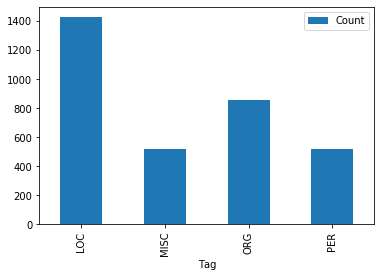

In [13]:
# Aggregating the tags to a dataframe with their frequencies of appearence
df_tags_grouped = df_labels.groupby(['Name','Tag']).agg({'Tweet':'count'})

df_tags_grouped.columns = ["Count"]
df_tags_grouped = df_tags_grouped.reset_index()
df_tags_grouped.head()

#Bar plot to understand the frequency
df_tags_grouped.groupby(['Tag']).agg({'Count':'sum'}).plot(kind = 'bar')

Visualizing location names tagged by the algorithm in word cloud using the wordcloud library.

In [14]:
import wordcloud as wc
import matplotlib.pyplot as plt

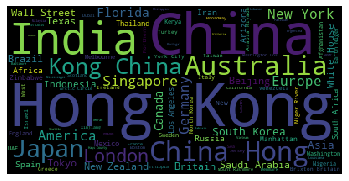

In [15]:
wordcloud2 = wc.WordCloud().generate(' '.join(df_labels[df_labels['Tag'] == 'LOC']['Name']))
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

## Conclusion and future plans

The notebook demonstrates the use of tweepy to pull out tweets from twitter real time.  A part of the objective is to classify the tweets to geographic identities. This capability has been demonstrated by using the flair library's Named entity recognition model with 4 category labeling. 

## Reference
1. https://www.tweepy.org/
2. https://github.com/flairNLP/flair
3. https://www.youtube.com/watch?v=1gQ6uG5Ujiw